In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
import numpy as np
import tensorflow as tf
import keras
from kerastuner import GridSearch
from kerastuner import RandomSearch
from kerastuner import Objective
from kerastuner import Hyperband
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Activation, Flatten
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\proxr\AppData\Local\Temp\ipykernel_2376\2200840416.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import GridSearch


### 1 Import der Daten

In [2]:
cardiovascular_data = pd.read_csv("ukbiobankdata.csv")
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,f.42000.0.0,f.42006.0.0
0,49,F,110.0,4.295,NaN,2.463,Never,2008-02-25,NaN,NaN
1,69,F,140.0,NaN,NaN,NaN,Never,2009-04-25,NaN,NaN
2,65,F,187.0,6.515,1.546,4.115,Never,2009-05-27,NaN,NaN
3,64,M,138.0,6.633,1.239,4.336,Previous,2009-06-26,2015-07-10,NaN
4,45,F,105.0,5.034,2.292,2.655,Never,2009-11-09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
477569,68,M,202.0,5.241,1.054,3.467,Never,2008-08-28,NaN,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,Previous,2008-10-11,NaN,NaN
477571,50,M,125.0,3.497,0.901,2.269,Never,2009-11-26,2004-06-30,NaN
477572,58,M,143.0,5.217,0.914,3.232,Previous,2010-03-09,NaN,NaN


### 2 Preprocessing

In [3]:
cardiovascular_data["SmokingStatus"].replace(["Current", "Previous"], 1, inplace=True)
cardiovascular_data["SmokingStatus"].replace("Never", 0, inplace=True)

In [4]:
cardiovascular_data["f.42000.0.0"] = pd.to_datetime(cardiovascular_data["f.42000.0.0"], format="%Y-%m-%d")
cardiovascular_data["f.42006.0.0"] = pd.to_datetime(cardiovascular_data["f.42006.0.0"], format="%Y-%m-%d")
cardiovascular_data.dtypes

Age                               int64
Sex                              object
SBP                             float64
Cholesterol                     float64
HDL                             float64
LDL                             float64
SmokingStatus                   float64
DateOfFirstAttendance            object
f.42000.0.0              datetime64[ns]
f.42006.0.0              datetime64[ns]
dtype: object

In [5]:
cardiovascular_data["DateOfCardiovascularEvent"] = np.nan

In [6]:
cardiovascular_data["DateOfCardiovascularEvent"] = pd.to_datetime(cardiovascular_data["DateOfCardiovascularEvent"], format="%Y-%m-%d")

In [7]:
# Sucht für jeden Patienten das frühere Datum heraus, falls ein Patient sowohl Herz- als auch Hininfarkt hatte.
for i in range(len(cardiovascular_data)):
    if(pd.isnull(cardiovascular_data.loc[i, "f.42000.0.0"]) and pd.isnull(cardiovascular_data.loc[i, "f.42006.0.0"])):
        if(cardiovascular_data.loc[i, "f.42000.0.0"] < cardiovascular_data.loc[i, "f.42006.0.0"]):
            cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42000.0.0"]
        else:
            cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42006.0.0"]
    if(pd.isnull(cardiovascular_data.loc[i,"f.42000.0.0"]) and not pd.isnull(cardiovascular_data.loc[i, "f.42006.0.0"])):
        cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42006.0.0"]
    else:
        cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42000.0.0"]

In [8]:
cardiovascular_data.drop(["f.42000.0.0", "f.42006.0.0"], axis=1, inplace=True)
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,DateOfCardiovascularEvent
0,49,F,110.0,4.295,NaN,2.463,0.0,2008-02-25,NaT
1,69,F,140.0,NaN,NaN,NaN,0.0,2009-04-25,NaT
2,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT
3,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10
4,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT
...,...,...,...,...,...,...,...,...,...
477569,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT
477571,50,M,125.0,3.497,0.901,2.269,0.0,2009-11-26,2004-06-30
477572,58,M,143.0,5.217,0.914,3.232,1.0,2010-03-09,NaT


In [9]:
cardiovascular_data.dropna(subset=["DateOfFirstAttendance"], inplace=True)

In [10]:
cardiovascular_data["DateOfFirstAttendance"] = pd.to_datetime(cardiovascular_data["DateOfFirstAttendance"], format="%Y-%m-%d")

In [11]:
for i in range(len(cardiovascular_data)):
    if(not pd.isnull(cardiovascular_data.loc[i, "DateOfFirstAttendance"]) and not pd.isnull(cardiovascular_data.loc[i, "DateOfCardiovascularEvent"])):
        if(cardiovascular_data.loc[i, "DateOfFirstAttendance"] > cardiovascular_data.loc[i, "DateOfCardiovascularEvent"]):
            cardiovascular_data.drop(i, inplace=True)

In [17]:
cardiovascular_data["DateOfCardiovascularEvent"].sort_values(ascending=False)

271437   2022-12-16
29696    2022-12-01
309012   2022-11-29
136761   2022-11-27
62849    2022-11-27
            ...    
477566          NaT
477567          NaT
477568          NaT
477570          NaT
477572          NaT
Name: DateOfCardiovascularEvent, Length: 393718, dtype: datetime64[ns]

In [13]:
cardiovascular_data.dropna(subset=["Age", "Sex", "SBP", "Cholesterol", "HDL", "LDL", "SmokingStatus"], inplace=True)

In [ ]:
cardiovascular_data

In [18]:
cardiovascular_data["diff_in_days"] = pd.to_datetime("2022-12-16") - pd.to_datetime("2006-03-13")

In [19]:
cardiovascular_data.reset_index(inplace=True, drop=True)

In [20]:
for i in range(len(cardiovascular_data)):
    if(not pd.isnull(cardiovascular_data.loc[i, "DateOfFirstAttendance"]) and not pd.isnull(cardiovascular_data.loc[i, "DateOfCardiovascularEvent"])):
        cardiovascular_data.loc[i, "diff_in_days"] = cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] - cardiovascular_data.loc[i, "DateOfFirstAttendance"]

In [21]:
cardiovascular_data.loc[1, "DateOfCardiovascularEvent"] - cardiovascular_data.loc[1, "DateOfFirstAttendance"]

Timedelta('2205 days 00:00:00')

In [22]:
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,DateOfCardiovascularEvent,diff_in_days
0,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT,6122 days
1,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10,2205 days
2,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT,6122 days
3,57,M,126.0,5.678,1.125,3.912,1.0,2008-09-26,NaT,6122 days
4,66,F,115.0,5.095,2.296,2.359,1.0,2010-06-30,NaT,6122 days
...,...,...,...,...,...,...,...,...,...,...
393713,45,F,152.0,5.994,1.243,4.057,0.0,2009-12-09,NaT,6122 days
393714,58,M,126.0,4.493,1.018,2.733,1.0,2008-03-14,NaT,6122 days
393715,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,2011-12-11,1200 days
393716,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT,6122 days


### 3 Berechnung der $\delta$

In [23]:
cardiovascular_data["delta"] = 10
for i in range(len(cardiovascular_data)):
    if(pd.isnull(cardiovascular_data.loc[i, "DateOfCardiovascularEvent"])):
        cardiovascular_data.loc[i, "delta"] = 0
    else:
        cardiovascular_data.loc[i, "delta"] = 1

In [24]:
cardiovascular_data.drop(["DateOfCardiovascularEvent", "DateOfFirstAttendance"], axis=1, inplace=True)

In [25]:
cardiovascular_data["diff_in_days"] = cardiovascular_data["diff_in_days"].dt.days.astype(float)

In [26]:
cardiovascular_data.to_csv("cvd_cleaned.csv")

### 4 Simulation unterschiedlicher Zensierungsraten (10%, 25%, 50% & 75)

In [2]:
cvd_cleaned = pd.read_csv("cvd_cleaned.csv", usecols=["Age", "Sex", "SBP", "Cholesterol", "HDL", "LDL", "SmokingStatus", "diff_in_days", "delta"])
cvd_cleaned

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,diff_in_days,delta
0,65,F,187.0,6.515,1.546,4.115,0.0,6122.0,0
1,64,M,138.0,6.633,1.239,4.336,1.0,2205.0,1
2,45,F,105.0,5.034,2.292,2.655,0.0,6122.0,0
3,57,M,126.0,5.678,1.125,3.912,1.0,6122.0,0
4,66,F,115.0,5.095,2.296,2.359,1.0,6122.0,0
...,...,...,...,...,...,...,...,...,...
393713,45,F,152.0,5.994,1.243,4.057,0.0,6122.0,0
393714,58,M,126.0,4.493,1.018,2.733,1.0,6122.0,0
393715,68,M,202.0,5.241,1.054,3.467,0.0,1200.0,1
393716,58,F,123.0,5.894,1.651,3.085,1.0,6122.0,0


Änderung der diff_in_days Spalte in Jahre, der Spaltenname bleibt aus codetechnischen Gründen aber bestehen.

In [3]:
cvd_cleaned["diff_in_days"] = cvd_cleaned["diff_in_days"] / 365
cvd_cleaned

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,diff_in_days,delta
0,65,F,187.0,6.515,1.546,4.115,0.0,16.772603,0
1,64,M,138.0,6.633,1.239,4.336,1.0,6.041096,1
2,45,F,105.0,5.034,2.292,2.655,0.0,16.772603,0
3,57,M,126.0,5.678,1.125,3.912,1.0,16.772603,0
4,66,F,115.0,5.095,2.296,2.359,1.0,16.772603,0
...,...,...,...,...,...,...,...,...,...
393713,45,F,152.0,5.994,1.243,4.057,0.0,16.772603,0
393714,58,M,126.0,4.493,1.018,2.733,1.0,16.772603,0
393715,68,M,202.0,5.241,1.054,3.467,0.0,3.287671,1
393716,58,F,123.0,5.894,1.651,3.085,1.0,16.772603,0


In [4]:
cvd_table = cvd_cleaned.head().to_latex("cvd_table.tex")

Kopie des DataFrames für spätere Zwecke

In [4]:
cvd_cleaned_copy = cvd_cleaned.copy()

Aktueller Anteil vollständig beobachteter Patienten

In [5]:
cvd_cleaned["delta"].value_counts()[1] / cvd_cleaned["delta"].value_counts()[0]

0.062250940927302406

In [6]:
def censor_distribution(data, distribution, RS):
    lower_class = data[data["delta"] == 1]
    upper_class = data[data["delta"] == 0]
    lower_count = len(lower_class)
    N = int(lower_count * distribution)

    class_balance = upper_class.sample(n=N, random_state=RS)

    new_data = pd.concat([lower_class, class_balance])
    return new_data

In [7]:
cvd_10 = censor_distribution(cvd_cleaned, 0.1, 3)
print(cvd_10["delta"].value_counts()[0] / cvd_10["delta"].value_counts()[1])
cvd_25 = censor_distribution(cvd_cleaned, 0.25, 214124)
print(cvd_25["delta"].value_counts()[0] / cvd_25["delta"].value_counts()[1])
cvd_50 = censor_distribution(cvd_cleaned, 0.5, 42)
print(cvd_50["delta"].value_counts()[0] / cvd_50["delta"].value_counts()[1])
cvd_75 = censor_distribution(cvd_cleaned, 0.75, 4134)
print(cvd_75["delta"].value_counts()[0] / cvd_75["delta"].value_counts()[1])

0.09998699778962424
0.24998916482468686
0.4999783296493737
0.7499674944740606


### 5 Onehot Encoding und Normalisierung der Daten

In [8]:
def do_onehot_and_scale(df):
    # OneHot Encoding für das Geschlechtsfeature
    dummy_df = pd.get_dummies(df["Sex"], prefix="Sex", dtype="float")
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(["Sex"], axis=1, inplace=True)

    # # OneHot Encoding für den SmokingStatus
    # dummy_df = pd.get_dummies(df["SmokingStatus"], prefix="SmokingStatus", dtype="float")
    # df = pd.concat([df, dummy_df], axis=1)
    # df.drop(["SmokingStatus"], axis=1, inplace=True)

    # Normalisierung
    scaler = MinMaxScaler()
    df[["Age", "SBP", "Cholesterol", "HDL", "LDL"]] = scaler.fit_transform(df[["Age", "SBP", "Cholesterol", "HDL", "LDL"]])
    return df

In [9]:
cvd_cleaned = do_onehot_and_scale(cvd_cleaned)
cvd_10 = do_onehot_and_scale(cvd_10)
cvd_25 = do_onehot_and_scale(cvd_25)
cvd_50 = do_onehot_and_scale(cvd_50)
cvd_75 = do_onehot_and_scale(cvd_75)

In [11]:
cvd_onehot_norm = cvd_cleaned.head().to_latex("cvd_onehot_norm.tex")

### 6 Aufteilung in Trainings- und Testdaten

In [11]:
def split_data(df, seed, test_size=0.2):
    shuffled = df.loc[np.random.RandomState(seed=seed).permutation(df.index)].reset_index(drop=True)
    test_df_size = int(len(shuffled) * test_size)
    train_df_size = int(len(shuffled) - test_df_size)
    df1 = shuffled.iloc[:test_df_size,:]
    df2 = shuffled.iloc[test_df_size:train_df_size+test_df_size,:]
    return df1, df2

In [12]:
test, train = split_data(cvd_cleaned, 4)
test10, train10 = split_data(cvd_10, 3434)
test25, train25 = split_data(cvd_25, 4534)
test50, train50 = split_data(cvd_50, 1236)
test75, train75 = split_data(cvd_75, 6456)

### 7 Gewichteberechnung

In [13]:
def weight_calc(df):
    df = df.sort_values(by="diff_in_days", ascending=True).reset_index(drop=True)

    # Weight Berechnung über die Surival function des KaplanMeierFitters von lifelines
    kmf = KaplanMeierFitter()
    kmf.fit(durations=df["diff_in_days"], event_observed=df["delta"], timeline=df["diff_in_days"].unique())
    
    # Berechnung der timeline für die Gewichte
    unique_diffs = pd.Series(df["diff_in_days"].unique())
    unique_diffs = pd.DataFrame(unique_diffs, columns=["timeline"])

    f_n = (kmf.survival_function_ - 1) * (-1)
    merged_df = pd.merge(f_n, unique_diffs, left_index=True, right_on=["timeline"], how="inner")
    
    # Gewichteberechnung
    merged_df["weights"] = 0
    for i in range(len(merged_df)-1):
        merged_df.loc[i, "weights"] = merged_df.loc[i+1, "KM_estimate"] - merged_df.loc[i, "KM_estimate"]

    # Übertragung in das richtige DataFrame
    df = pd.merge(df, merged_df, left_on="diff_in_days", right_on="timeline").drop(labels = ["KM_estimate","timeline"], axis=1)
    
    return df

In [14]:
train = weight_calc(train)
test = weight_calc(test)
train10 = weight_calc(train10)
test10 = weight_calc(test10)
train25 = weight_calc(train25)
test25 = weight_calc(test25)
train50 = weight_calc(train50)
test50 = weight_calc(test50)
train75 = weight_calc(train75)
test75 = weight_calc(test75)

In [15]:
print("Train Weightssum: ", train["weights"].unique().sum(), "n=", len(train))
print("Test Weightssum: ", test["weights"].unique().sum(), "n=", len(test))
print("Train10 Weightssum: ", train10["weights"].unique().sum(), "n=", len(train10))
print("Test10 Weightssum: ", test10["weights"].unique().sum(), "n=", len(test10))
print("Train25 Weightssum: ", train25["weights"].unique().sum(), "n=", len(train25))
print("Test25 Weightssum: ", test25["weights"].unique().sum(), "n=", len(test25))
print("Train50 Weightssum: ", test25["weights"].unique().sum(), "n=", len(train50))
print("Test50 Weightssum: ", test50["weights"].unique().sum(), "n=", len(test50))
print("Train75 Weightssum: ", train75["weights"].unique().sum(), "n=", len(train75))
print("Test75 Weightssum: ", test75["weights"].unique().sum(), "n=", len(test75))

Train Weightssum:  0.005416302881172674 n= 314975
Test Weightssum:  0.0041908487103583525 n= 78743
Train10 Weightssum:  0.060923955870771596 n= 20304
Test10 Weightssum:  0.05023640661939077 n= 5076
Train25 Weightssum:  0.05439258007194969 n= 23073
Test25 Weightssum:  0.04993065187240586 n= 5768
Train50 Weightssum:  0.04993065187240586 n= 27688
Test50 Weightssum:  0.04233492269903272 n= 6921
Train75 Weightssum:  0.043000433409686734 n= 32302
Test75 Weightssum:  0.03690402476779886 n= 8075


### 8 Aufteilung in Input-, Target- und Gewichtdaten

In [15]:
def split_input_target(df):
    df.drop("delta", inplace=True, axis=1)
    X = df[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus"]]
    y = tf.constant(df["diff_in_days"], dtype="float32")
    weights = tf.constant(df["weights"], dtype="float32")
    return X, y, weights

In [16]:
X_train, y_train, weights_train = split_input_target(train)
X_test, y_test, weights_test = split_input_target(test)
X_train10, y_train10, weights_train10 = split_input_target(train10)
X_test10, y_test10, weights_test10 = split_input_target(test10)
X_train25, y_train25, weights_train25 = split_input_target(train25)
X_test25, y_test25, weights_test25 = split_input_target(test25)
X_train50, y_train50, weights_train50 = split_input_target(train50)
X_test50, y_test50, weights_test50 = split_input_target(test50)
X_train75, y_train75, weights_train75 = split_input_target(train75)
X_test75, y_test75, weights_test75 = split_input_target(test75)

### 9 Erstellung der Neuronalen Netze

In [16]:
@keras.saving.register_keras_serializable(package="squared_weighted_loss")
class squared_weighted_loss(tf.keras.losses.Loss):

    def __init__(self, km_weights):
        super().__init__()
        self.km_weights = km_weights

    def call(self, y_true, y_pred):
        squared_loss = tf.square(y_true - y_pred)
        custom_loss = tf.reduce_sum(squared_loss * self.km_weights)
        return custom_loss
    
    def get_config(self):
        return {"km_weights": self.km_weights}

    @classmethod
    def from_config(cls, config):
        weights_config = config.pop("km_weights")
        km_weights = keras.saving.deserialize_keras_object(weights_config)
        return cls(km_weights, **config)


In [17]:
def custom_weighted_loss(y_true, y_pred, weights):
    squared_loss = tf.square(y_true - y_pred)
    custom_loss = tf.reduce_sum(squared_loss * weights)
    return custom_loss

In [18]:
custom_loss = squared_weighted_loss(km_weights=weights_train)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=(8,), activation='relu', dtype="float32"),
    tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
    tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
    tf.keras.layers.Dense(1, activation='linear', dtype="float32")
])
model.compile(optimizer='adam', loss="mean_squared_error", weighted_metrics=[])

In [19]:
model.fit(x=X_train, y=y_train, epochs=5, batch_size=1, sample_weight=weights_train)

Epoch 1/5

314975/314975 [==============================] - 239s 757us/step - loss: 8.8323e-06
Epoch 2/5
314975/314975 [==============================] - 233s 741us/step - loss: 8.4275e-06
Epoch 3/5
314975/314975 [==============================] - 237s 752us/step - loss: 8.4168e-06
Epoch 4/5
314975/314975 [==============================] - 233s 739us/step - loss: 8.4041e-06
Epoch 5/5
314975/314975 [==============================] - 231s 732us/step - loss: 8.4032e-06


### 10 Hyperparametertuning mit KerasTuner

In [18]:
def create_base_model(hp):
    
    model = Sequential()
    
    model.add(Dense(8, input_dim=8, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_uniform(seed=42)))
    # model.add(Dense(128, activation=tf.nn.relu, dtype="float32"))
    # model.add(Dense(128, activation=tf.nn.relu, dtype="float32"))
    num_layers = hp.Int("num_layers", min_value=1, max_value=5, step=1)
    
    # Layer, activation, units und Dropoutchoice
    for i in range(num_layers):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                                     activation=hp.Choice("activation", ["relu", "sigmoid", "leaky_relu", "swish"])))

        use_dropout = hp.Boolean(f'use_dropout_{i}', default=False)
        if use_dropout:
            # Dropout-Layer mit Dropout-Rate als Hyperparameter
            dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1, default=0.2)
            model.add(keras.layers.Dropout(rate=dropout_rate))
    
    # Optimizer und Learningrate Choice
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adagrad'])
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-3))
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp.Float('learning_rate_sgd', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2))
    elif optimizer_choice == "adagrad":
        optimizer = keras.optimizers.Adagrad(learning_rate=hp.Float('learning_rate_adagrad', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2))
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate_rmsprop', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-3))
    
    
    model.add(keras.layers.Dense(units=1, activation='linear'))
    
    # custom_loss = squared_weighted_loss(km_weights=weights_train)
    model.compile(loss="mean_squared_error", optimizer = optimizer, weighted_metrics=[])
    return model

In [19]:
tuner = GridSearch(
    create_base_model,
    objective=Objective("loss", direction="min"),
    max_trials=100,
    directory="/nn_survival_analysis20/",
    project_name='my_tuning_project'
)

In [20]:
tuner3 = RandomSearch(
    create_base_model,
    objective=Objective("loss", direction="min"),
    max_trials=100,
    directory="/nn_survival_analysis21/",
    project_name='my_tuning_project'
)

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1, min_delta=0.001, start_from_epoch=2)
stop_early_nan = tf.keras.callbacks.TerminateOnNaN()

In [22]:
tuner.search(x=X_train, 
             y=y_train, 
             epochs=10, 
             validation_data=(X_test, y_test), 
             batch_size=16,
             callbacks=[stop_early, stop_early_nan],
             sample_weight=weights_train)

Trial 100 Complete [00h 01m 09s]
loss: 6.132569251349196e-05

Best loss So Far: 8.315152626892086e-06
Total elapsed time: 01h 55m 03s


In [23]:
tuner3.search(
    x=X_train,
    y = y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=16,
    callbacks=[stop_early, stop_early_nan],
    sample_weight=weights_train
)

Trial 100 Complete [00h 01m 22s]
loss: 5.021597826271318e-05

Best loss So Far: 8.289927791338414e-06
Total elapsed time: 03h 12m 16s


In [30]:
best_hps3 = tuner.get_best_hyperparameters(5)
model = create_base_model(best_hps3[0])
model.save("gridsearch.keras")

In [39]:
tuner.results_summary(1)

Results summary
Results in /nn_survival_analysis20/my_tuning_project
Showing 1 best trials
Objective(name="loss", direction="min")

Trial 010 summary
Hyperparameters:
num_layers: 1
units_0: 32
activation: relu
use_dropout_0: False
optimizer: adam
learning_rate_adam: 0.00028183829312644545
Score: 8.315152626892086e-06


In [33]:
gridsearch_model = tf.keras.models.load_model("gridsearch.keras")

In [29]:
best_hps = tuner3.get_best_hyperparameters(5)
model = create_base_model(best_hps[0])
model.save("randomsearch.keras")

In [31]:
random_search_model = tf.keras.models.load_model("randomsearch.keras")

In [40]:
tuner3.results_summary(1)

Results summary
Results in /nn_survival_analysis21/my_tuning_project
Showing 1 best trials
Objective(name="loss", direction="min")

Trial 029 summary
Hyperparameters:
num_layers: 1
units_0: 384
activation: sigmoid
use_dropout_0: True
optimizer: adam
learning_rate_adam: 0.010066872951858362
units_1: 96
use_dropout_1: False
learning_rate_sgd: 0.008463787018388728
dropout_rate_1: 0.1
units_2: 160
use_dropout_2: True
units_3: 448
use_dropout_3: False
units_4: 96
use_dropout_4: False
learning_rate_adagrad: 0.0964958086533842
dropout_rate_2: 0.4
learning_rate_rmsprop: 0.00017762922812496933
dropout_rate_3: 0.0
dropout_rate_0: 0.30000000000000004
dropout_rate_4: 0.4
Score: 8.289927791338414e-06


In [34]:
gridsearch_model.evaluate(x=X_test, y=y_test, sample_weight=weights_test)

2461/2461 [==============================] - 2s 663us/step - loss: 9.6811e-05


9.681091614766046e-05

In [35]:
random_search_model.evaluate(x=X_test, y=y_test, sample_weight=weights_test)

2461/2461 [==============================] - 2s 661us/step - loss: 1.0311e-04


0.00010311140795238316

Test, ob die unzensierten oder zensierten Daten besser sind

In [41]:
copy2 = cvd_cleaned_copy.copy()

In [42]:
cvd = do_onehot_and_scale(copy2)
cvd = weight_calc(cvd)
cvd_uncensored = cvd[cvd["delta"] == 1]
cvd_censored = cvd[cvd["delta"] == 0]
cvd_uncensored.drop(["weights", "delta"], axis=1, inplace=True)
cvd_censored.drop(["weights", "delta"], axis=1, inplace=True)
cvd_uncensored_x = cvd_uncensored[["Age", "SBP", "Cholesterol", "HDL", "LDL", "SmokingStatus", "Sex_F", "Sex_M"]]
cvd_uncensored_y = cvd_uncensored["diff_in_days"]
cvd_censored_x = cvd_censored[["Age", "SBP", "Cholesterol", "HDL", "LDL", "SmokingStatus", "Sex_F", "Sex_M"]]
cvd_censored_y = cvd_censored["diff_in_days"]

C:\Users\proxr\AppData\Local\Temp\ipykernel_2376\2919881648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvd_uncensored.drop(["weights", "delta"], axis=1, inplace=True)
C:\Users\proxr\AppData\Local\Temp\ipykernel_2376\2919881648.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvd_censored.drop(["weights", "delta"], axis=1, inplace=True)


In [43]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(8, input_shape=(8,), activation='relu', dtype="float32"),
            tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
            tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
            tf.keras.layers.Dense(1, activation='linear', dtype="float32")
        ])

In [44]:
model.compile(optimizer='adam', loss="mean_squared_error", weighted_metrics=[])
model.fit(x=X_train, y=y_train, epochs=5, batch_size=8, sample_weight=weights_train)

Epoch 1/5
39372/39372 [==============================] - 34s 838us/step - loss: 8.8876e-06
Epoch 2/5
39372/39372 [==============================] - 33s 830us/step - loss: 8.5531e-06
Epoch 3/5
39372/39372 [==============================] - 32s 824us/step - loss: 8.4872e-06
Epoch 4/5
39372/39372 [==============================] - 33s 826us/step - loss: 8.4370e-06
Epoch 5/5
39372/39372 [==============================] - 33s 826us/step - loss: 8.4091e-06


In [45]:
model.evaluate(x=cvd_censored_x, y=cvd_censored_y, batch_size=8)

46331/46331 [==============================] - 32s 682us/step - loss: 72.6741


72.67405700683594

In [46]:
model.evaluate(x=cvd_uncensored_x, y=cvd_uncensored_y, batch_size=8)

2885/2885 [==============================] - 2s 697us/step - loss: 14.3282


14.328184127807617

### 11 Performance nach Zensierungsrate

In [29]:
def test_censor_performance(df, censorrate, train_weights, test_weights):
    loss_df = pd.DataFrame(columns=["train_loss", "test_loss"])
    pack = 0 
    packs = 50
    while pack < packs:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(8, input_shape=(8,), activation='relu', dtype="float32"),
            tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
            tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
            tf.keras.layers.Dense(1, activation='linear', dtype="float32")
        ])
    
        model.compile(optimizer='adam', loss="mean_squared_error", weighted_metrics=[])
        state = np.random.randint(1, 1000, 1)
        data = df.copy()
        data = censor_distribution(data, censorrate, state)
        data = do_onehot_and_scale(data)
        df1, df2 = split_data(data, seed=state)
        df1 = weight_calc(df1)
        df2 = weight_calc(df2)
        train_x, train_y, train_weights = split_input_target(df1)
        test_x, test_y, test_weights = split_input_target(df2)
        history = model.fit(train_x, train_y, epochs=5, batch_size=8, verbose=0, sample_weight=train_weights)
        test_loss = model.evaluate(test_x, test_y, batch_size=8, verbose=0, sample_weight=test_weights)
        loss_df.loc[pack] = (history.history["loss"][-1], test_loss)
        pack+=1
        print("Pack ", pack , "/" , packs)
        clear_output(wait=True)
    return loss_df

In [30]:
censor_performance_10 = test_censor_performance(cvd_cleaned_copy, 0.1, weights_train10, weights_test10)

Pack  50 / 50


In [31]:
censor_performance_25 = test_censor_performance(cvd_cleaned_copy, 0.25, weights_train25, weights_test25)

Pack  50 / 50


In [32]:
censor_performance_50 = test_censor_performance(cvd_cleaned_copy, 0.5, weights_train50, weights_test50)

Pack  50 / 50


In [33]:
censor_performance_75 = test_censor_performance(cvd_cleaned_copy, 0.75, weights_train75, weights_test75)

Pack  50 / 50


In [34]:
censor_performance_default = test_censor_performance(cvd_cleaned_copy, 1, weights_train, weights_test)

Pack  50 / 50


In [35]:
def custom_scientific_format(x):
    return "{:e}".format(x)
pd.set_option('display.float_format', custom_scientific_format)

In [36]:
censor_performance_10.rename(columns={"train_loss": "train_loss_10", "test_loss": "test_loss_10"}, inplace=True)
censor_performance_25.rename(columns={"train_loss": "train_loss_25", "test_loss": "test_loss_25"}, inplace=True)
censor_performance_50.rename(columns={"train_loss": "train_loss_50", "test_loss": "test_loss_50"}, inplace=True)
censor_performance_75.rename(columns={"train_loss": "train_loss_75", "test_loss": "test_loss_75"}, inplace=True)
censor_performance_default.rename(columns={"train_loss": "train_loss_default", "test_loss": "test_loss_default"}, inplace=True)

In [37]:
performance_data = pd.concat([censor_performance_10, censor_performance_25, censor_performance_50, censor_performance_75, censor_performance_default], axis=1)

Text(0.5, 1.0, 'Vergleich Trainings- und Testloss der verschiedenen Zensierungsraten')

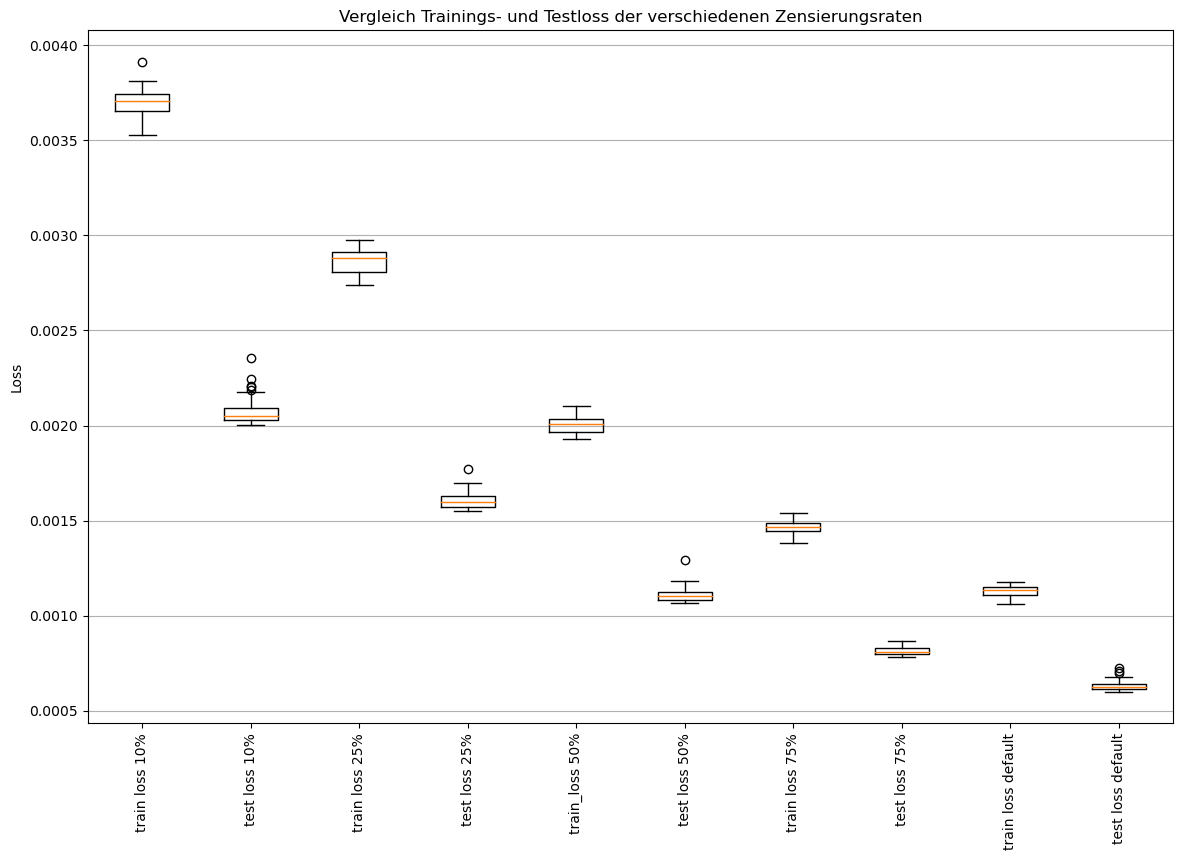

In [38]:
plt.figure(figsize=(14,9))
plt.boxplot(performance_data, labels=["train loss 10%", "test loss 10%", 
                                      "train loss 25%", "test loss 25%", 
                                      "train_loss 50%", "test loss 50%", 
                                      "train loss 75%", "test loss 75%", 
                                      "train loss default", "test loss default"])
plt.xticks(rotation=90)
plt.grid(zorder=2, axis="y")
plt.ylabel("Loss")
plt.title("Vergleich Trainings- und Testloss der verschiedenen Zensierungsraten")

In [39]:
pd.reset_option('display.float_format')

### 12 Test ohne Gewichte

In [40]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(8, input_shape=(8,), activation='relu', dtype="float32"),
            tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
            tf.keras.layers.Dense(128, activation="relu", dtype="float32"),
            tf.keras.layers.Dense(1, activation='linear', dtype="float32")
        ])

model.compile(optimizer='adam', loss="mean_squared_error")
model.fit(x=X_train, y=y_train, epochs=5, batch_size=8)

Epoch 1/5
39372/39372 [==============================] - 33s 830us/step - loss: 5.1941
Epoch 2/5
39372/39372 [==============================] - 32s 823us/step - loss: 4.8617
Epoch 3/5
39372/39372 [==============================] - 32s 819us/step - loss: 4.8519
Epoch 4/5
39372/39372 [==============================] - 32s 806us/step - loss: 4.8390
Epoch 5/5
39372/39372 [==============================] - 32s 807us/step - loss: 4.8356
